# Additional trading strategies
***
Find a strategy that leads to a profit when transaction costs are present

Idea is to also use the data about Volume of trades

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("BTCUSDT_price_data_2024-01-24-2.csv")
df["timestamp"] = df["timestamp"].astype(str).str.replace(r"[^0-9]", "", regex=True)
df["timestamp"] = df["timestamp"].astype(float) / 1000
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df = df.set_index("datetime")
df.head()

,timestamp,mid_price,volume
datetime,,,
2024-01-24 00:00:00,1.706054e+09,39881.95,439.561
2024-01-24 00:01:00,1.706054e+09,39926.55,776.492
2024-01-24 00:02:00,1.706055e+09,39877.05,339.306
2024-01-24 00:03:00,1.706055e+09,39927.45,246.511
2024-01-24 00:04:00,1.706055e+09,39926.55,423.920


### Strategy Description — SMA with Relative Volume Filter

#### Overview
This trading strategy combines **price trends** with **volume-based confirmation** to identify moments when the market is both moving and active.  
It extends the basic moving average crossover approach by introducing a **relative volume condition** that must be met before any trade is executed.

#### Core Components
- **Simple Moving Average (SMA):**  
  Represents the underlying trend of the mid-price over a chosen window (e.g., 20 or 50 periods).
  
- **Relative Volume (RV):**  
  Measures how current trading activity compares to the recent average:  
  $$
  RV_t = \frac{V_t}{\text{mean}(V_{t-n:t})}
  $$
  where \( V_t \) is the current volume and \( n \) is the rolling window length.

#### Trading Rules
- **Go Long:**  
  When price crosses above the SMA *and* relative volume exceeds a chosen threshold (e.g., 1.5).  
  This means price is trending upward during a period of unusually high activity.

- **Go Short:**  
  When price crosses below the SMA *and* relative volume exceeds the same threshold.  
  This indicates a strong downward move supported by significant market participation.

- **Stay Flat:**  
  When volume activity is low, or price movements occur without sufficient confirmation from volume.


In [3]:
def compute_signal(
    df: pd.DataFrame,
    price_col: str = "mid_price",
    volume_col: str = "volume",
    sma_window: int = 20,
    relvol_window: int = 30,
    relvol_threshold: float = 1.5,
):
    """
    Build the m4 signal:
      long if price > SMA and relative volume >= threshold
      short if price < SMA and relative volume >= threshold
      else flat
    Returns a copy with columns: sma, vol_ma, rel_vol, signal
    """
    out = df.copy()

    out["sma"] = out[price_col].rolling(window=sma_window).mean()
    out["vol_ma"] = out[volume_col].rolling(window=relvol_window).mean()
    out["rel_vol"] = out[volume_col] / out["vol_ma"]

    sig = pd.Series(0.0, index=out.index)
    long_mask = (out[price_col] > out["sma"]) & (out["rel_vol"] >= relvol_threshold)
    short_mask = (out[price_col] < out["sma"]) & (out["rel_vol"] >= relvol_threshold)
    sig[long_mask] = 1.0
    sig[short_mask] = -1.0

    out["signal"] = sig
    return out


In [4]:
def backtest(
    df: pd.DataFrame,
    price_col: str = "mid_price",
    volume_col: str = "volume",
    sma_window: int = 20,
    relvol_window: int = 30,
    relvol_threshold: float = 1.5,
    initial_capital: float = 100_000.0,
    transaction_cost_pct: float = 0.0002,   # 0.02 percent per side
    allow_short_enter: bool = False,
):
    """
    Backtest the m4 rule with full capital long or short
    Costs are applied per executed side
    Returns df_out and a metrics dict
    """
    # build signal
    df_sig = compute_signal(
        df,
        price_col=price_col,
        volume_col=volume_col,
        sma_window=sma_window,
        relvol_window=relvol_window,
        relvol_threshold=relvol_threshold,
    ).copy()

    # hold position through time with first entry control
    sig_filled = df_sig["signal"].replace(0, np.nan).ffill()
    position = []
    in_position = False
    current_pos = 0.0
    for s in sig_filled:
        if pd.isna(s) or s == 0:
            pos = current_pos if in_position else 0.0
        else:
            if not in_position:
                if s == -1.0 and not allow_short_enter:
                    pos = 0.0
                else:
                    current_pos = float(s)
                    in_position = True
                    pos = current_pos
            else:
                if s != current_pos:
                    current_pos = float(s)
                pos = current_pos
        position.append(pos)

    df_sig["position"] = position

    # returns and equity
    df_sig["asset_return"] = df_sig[price_col].pct_change().fillna(0.0)
    df_sig["strategy_return_gross"] = df_sig["position"].shift(1).fillna(0.0) * df_sig["asset_return"]

    pos_diff = df_sig["position"].diff().fillna(0.0).abs()
    executed_sides = pos_diff                      # 0, 1, or 2
    df_sig["tx_cost"] = executed_sides * transaction_cost_pct

    df_sig["strategy_return"] = df_sig["strategy_return_gross"] - df_sig["tx_cost"]
    df_sig["equity"] = (1.0 + df_sig["strategy_return"]).cumprod() * initial_capital

    # metrics
    trades = int((pos_diff > 0).sum())
    final_equity = float(df_sig["equity"].iloc[-1])
    total_return_pct = (final_equity / initial_capital - 1.0) * 100.0

    roll_max = df_sig["equity"].cummax()
    drawdown = df_sig["equity"] / roll_max - 1.0
    max_drawdown_pct = float(drawdown.min() * 100.0)

    rets = df_sig["strategy_return"].dropna()
    mu = rets.mean()
    sigma = rets.std(ddof=0)
    minutes_per_year = 365 * 24 * 60
    sharpe = float((mu / sigma) * np.sqrt(minutes_per_year)) if sigma not in (0.0, np.nan) else np.nan

    metrics = {
        "final_equity": final_equity,
        "total_return_pct": float(total_return_pct),
        "max_drawdown_pct": max_drawdown_pct,
        "sharpe": sharpe,
        "num_trades": trades,
        "sma_window": sma_window,
        "relvol_window": relvol_window,
        "relvol_threshold": relvol_threshold,
        "transaction_cost_pct": float(transaction_cost_pct),
        "allow_short_enter": bool(allow_short_enter),
    }
    return df_sig, metrics


In [5]:
import itertools

def run_sweep(
    df: pd.DataFrame,
    sma_windows=(5, 10, 20, 50),
    relvol_windows=(20, 30, 50),
    relvol_thresholds=(1.2, 1.5, 2.0),
    price_col: str = "mid_price",
    volume_col: str = "volume",
    initial_capital: float = 100_000.0,
    transaction_cost_pct: float = 0.0002,
    allow_short_enter: bool = False,
):
    """
    Grid sweep for m4 across SMA windows, relative volume windows, and thresholds
    Returns a metrics table plus dicts for result frames and equity series
    """
    rows = []
    results_by_cfg = {}
    equities = {}

    for sma_w, rv_w, rv_thr in itertools.product(sma_windows, relvol_windows, relvol_thresholds):
        df_res, mets = backtest(
            df,
            price_col=price_col,
            volume_col=volume_col,
            sma_window=sma_w,
            relvol_window=rv_w,
            relvol_threshold=rv_thr,
            initial_capital=initial_capital,
            transaction_cost_pct=transaction_cost_pct,
            allow_short_enter=allow_short_enter,
        )

        label = f"m4 SMA{sma_w} RVW{rv_w} RVT{rv_thr}"
        rows.append({
            "label": label,
            "sma_window": sma_w,
            "relvol_window": rv_w,
            "relvol_threshold": rv_thr,
            "final_equity": mets["final_equity"],
            "total_return_pct": mets["total_return_pct"],
            "max_drawdown_pct": mets["max_drawdown_pct"],
            "sharpe": mets["sharpe"],
            "num_trades": mets["num_trades"],
            "cost_per_side_pct": transaction_cost_pct * 100.0,
            "allow_short_enter": allow_short_enter,
        })
        results_by_cfg[label] = df_res
        equities[label] = df_res["equity"]

    metrics_df = pd.DataFrame(rows).sort_values(
        by=["total_return_pct", "sharpe"],
        ascending=[False, False]
    ).reset_index(drop=True)

    return metrics_df, results_by_cfg, equities


In [20]:
# sweep
sma_windows = np.arange(2,60,2)
relvol_windows = np.arange(5,60,5)
relvol_thresholds = np.arange(1.1,3.0,0.2)
metrics_m4, results_m4, equities_m4 = run_sweep(
    df,
    sma_windows=sma_windows,
    relvol_windows=relvol_windows,
    relvol_thresholds=relvol_thresholds,
    transaction_cost_pct=0.0002,
    allow_short_enter=False,
)

metrics_m4.head()

,label,sma_window,relvol_window,relvol_threshold,final_equity,total_return_pct,max_drawdown_pct,sharpe,num_trades,cost_per_side_pct,allow_short_enter
0,m4 SMA8 RVW45 RVT2.0999999999999996,8,45,2.1,101633.774066,1.633774,-2.201543,13.265144,27,0.02,False
1,m4 SMA24 RVW55 RVT1.3,24,55,1.3,101581.179862,1.581180,-1.667130,12.928729,39,0.02,False
2,m4 SMA2 RVW55 RVT2.8999999999999995,2,55,2.9,101308.523500,1.308523,-1.597729,11.093375,25,0.02,False
3,m4 SMA4 RVW45 RVT2.0999999999999996,4,45,2.1,101242.076634,1.242077,-1.719279,10.090385,33,0.02,False
4,m4 SMA16 RVW45 RVT1.1,16,45,1.1,101200.155713,1.200156,-2.508423,9.646508,62,0.02,False


In [25]:
df_m4, m_m4 = backtest(
    df,
    sma_window=8,
    relvol_window=45,
    relvol_threshold=2.1,
    transaction_cost_pct=0.0002,
    allow_short_enter=False,
)


In [26]:
m_m4

{'final_equity': 101633.77406633041,
 'total_return_pct': 1.6337740663304068,
 'max_drawdown_pct': -2.2015426876419997,
 'sharpe': 13.265144119975233,
 'num_trades': 27,
 'sma_window': 8,
 'relvol_window': 45,
 'relvol_threshold': 2.1,
 'transaction_cost_pct': 0.0002,
 'allow_short_enter': False}

In [22]:

def plot_strategy_overview_m4(
    df: pd.DataFrame,
    n_points: int = 200,
    price_col: str = "mid_price",
    sma_col: str = "sma",
    signal_col: str = "signal",
    position_col: str = "position",
    equity_col: str = "equity",
    relvol_col: str = "rel_vol",
    vol_ma_col: str = "vol_ma",
    volume_col: str = "volume",
    tx_cost_col: str = "tx_cost",
    relvol_threshold: float = None,
    title: str = None,
    shade_zones: bool = True,
):
    """
    Plot a complete m4 overview:
      Top     Price and SMA with entry markers and position shading
      Middle  Volume and relative volume with optional threshold line and transaction costs
      Bottom  Equity and drawdown

    Parameters
    ----------
    df : DataFrame with required columns
    n_points : number of initial rows to display, None or <= 0 to plot all
    relvol_threshold : draw a horizontal line at this value if provided
    """

    if n_points is None or n_points <= 0:
        subset = df
        n_show = len(df)
    else:
        subset = df.iloc[:min(n_points, len(df))]
        n_show = len(subset)

    # Precompute drawdown from equity
    equity = subset[equity_col]
    roll_max = equity.cummax()
    drawdown = equity / roll_max - 1.0

    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.2, 1.6], hspace=0.25)

    # Top panel: price, SMA, signals, position shading
    ax_price = fig.add_subplot(gs[0, 0])
    ax_price.plot(subset.index, subset[price_col], label="Price", linewidth=1.3)
    ax_price.plot(subset.index, subset[sma_col], label="SMA", linewidth=1.6)

    long_sig = subset[subset[signal_col] == 1]
    short_sig = subset[subset[signal_col] == -1]
    ax_price.scatter(long_sig.index, long_sig[price_col], label="Long signal", marker="^", s=55, zorder=5)
    ax_price.scatter(short_sig.index, short_sig[price_col], label="Short signal", marker="v", s=55, zorder=5)

    if shade_zones:
        ymin = subset[price_col].min()
        ymax = subset[price_col].max()
        ax_price.fill_between(subset.index, ymin, ymax, where=subset[position_col] > 0, alpha=0.08, label="Long zone")
        ax_price.fill_between(subset.index, ymin, ymax, where=subset[position_col] < 0, alpha=0.08, label="Short zone")

    ax_price.set_ylabel("Price")
    if title is None:
        title = f"Strategy overview first {n_show} points"
    ax_price.set_title(title)
    ax_price.grid(True)
    ax_price.legend(loc="upper left")

    # Middle panel: volume, relative volume, threshold line, and transaction costs as stems
    ax_vol = fig.add_subplot(gs[1, 0], sharex=ax_price)
    if volume_col in subset.columns:
        ax_vol.plot(subset.index, subset[volume_col], label="Volume", linewidth=1.0, alpha=0.8)
    if vol_ma_col in subset.columns:
        ax_vol.plot(subset.index, subset[vol_ma_col], label="Volume MA", linewidth=1.2, alpha=0.9)
    if relvol_col in subset.columns:
        ax_vol_2 = ax_vol.twinx()
        ax_vol_2.plot(subset.index, subset[relvol_col], label="Relative volume", linewidth=1.2, linestyle="--")
        if relvol_threshold is not None:
            ax_vol_2.axhline(relvol_threshold, linestyle=":", linewidth=1.2, label=f"RV threshold {relvol_threshold}")
        ax_vol_2.set_ylabel("Relative volume")
        # merge legends
        lines1, labels1 = ax_vol.get_legend_handles_labels()
        lines2, labels2 = ax_vol_2.get_legend_handles_labels()
        ax_vol.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
    else:
        ax_vol.legend(loc="upper left")

    # transaction costs as small stems if present
    if tx_cost_col in subset.columns:
        tc = subset[tx_cost_col].fillna(0.0)
        if tc.abs().sum() > 0:
            ax_vol.stem(subset.index, tc.values, linefmt=":", markerfmt=" ", basefmt=" ", label="Tx cost per bar")

    ax_vol.set_ylabel("Volume")
    ax_vol.grid(True)

    # Bottom panel: equity and drawdown
    ax_eq = fig.add_subplot(gs[2, 0], sharex=ax_price)
    ax_eq.plot(subset.index, equity, label="Equity", linewidth=1.8)
    ax_eq.axhline(float(df[equity_col].iloc[0]), linestyle="--", linewidth=1.0, label="Initial capital")

    ax_dd = ax_eq.twinx()
    ax_dd.plot(subset.index, drawdown * 100.0, label="Drawdown percent", linewidth=1.2, linestyle="--", alpha=0.9)

    ax_eq.set_xlabel("Time")
    ax_eq.set_ylabel("Equity USD")
    ax_dd.set_ylabel("Drawdown percent")

    ax_eq.grid(True)

    # merge legends for bottom axes
    l1, lab1 = ax_eq.get_legend_handles_labels()
    l2, lab2 = ax_dd.get_legend_handles_labels()
    ax_eq.legend(l1 + l2, lab1 + lab2, loc="upper left")

    plt.tight_layout()
    plt.show()
    return fig, (ax_price, ax_vol), (ax_eq, ax_dd)


/tmp/ipykernel_86299/467830582.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


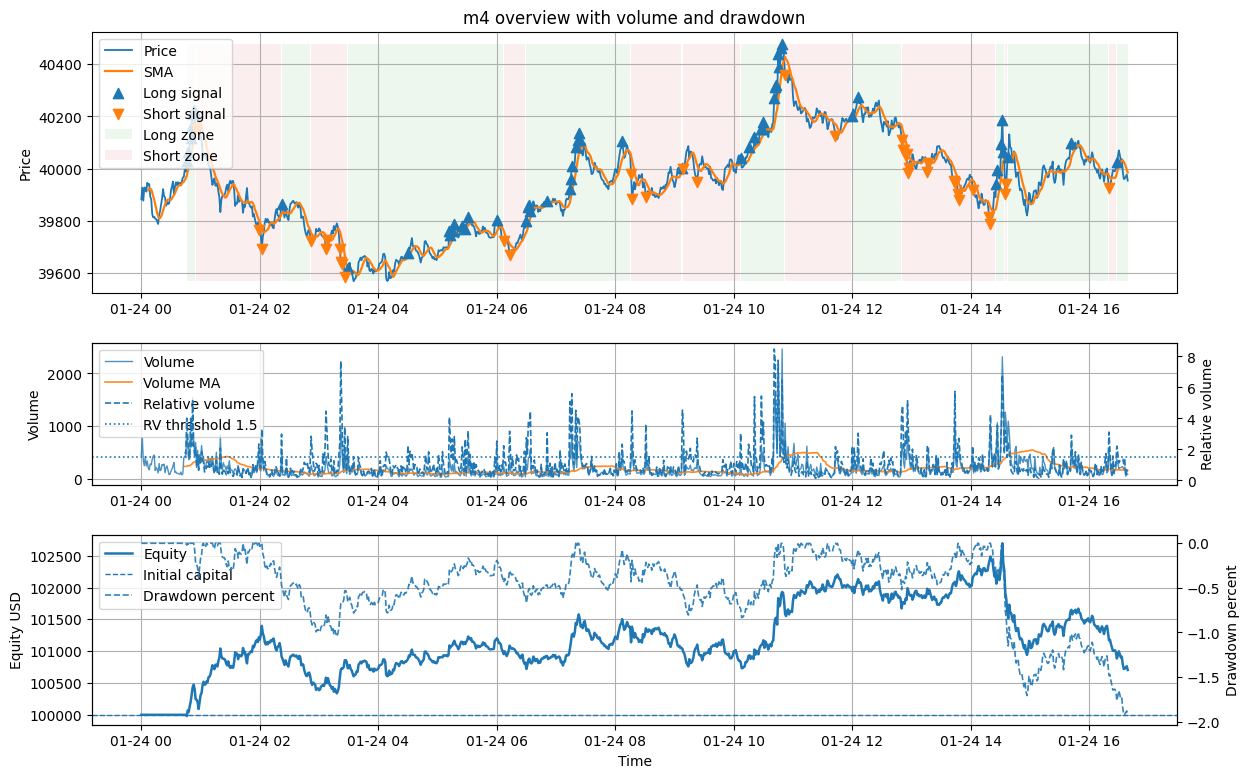

In [24]:
# After backtest_m4
_ = plot_strategy_overview_m4(
    df_m4,
    n_points=1000,
    relvol_threshold=1.5,   # show your chosen threshold
    title="m4 overview with volume and drawdown"
)
